In [6]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random


In [7]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [8]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [9]:
class DQN(nn.Module):
    """Neural Network to approximate Q-values - REPLACES Q-table from previous lab"""
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return self.network(x)


In [10]:
class DQNAgent:
    """Deep Q-Network Agent - EXTENDS concept from Q_Agent but uses neural network"""
    def __init__(self, environment, epsilon=0.1, learning_rate=0.001, gamma=0.99):
        self.environment = environment
        self.epsilon = epsilon  # Exploration rate
        self.gamma = gamma      # Discount factor
        self.input_size = 2     # (x, y) coordinates - STATE REPRESENTATION
        self.output_size = len(environment.actions)  # Number of actions

        # NEURAL NETWORK replaces q_table from previous lab
        self.q_network = DQN(self.input_size, self.output_size)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

    def state_to_tensor(self, state):
        """Convert state to tensor for neural network input"""
        return torch.FloatTensor(state)

    def choose_action(self, available_actions):
        """Epsilon-greedy action selection - SIMILAR to previous but uses neural network"""
        if random.random() < self.epsilon:
            return random.choice(available_actions)  # Exploration

        # Exploitation: use neural network to choose best action
        state = self.environment.current_location
        state_tensor = self.state_to_tensor(state)
        with torch.no_grad():
            q_values = self.q_network(state_tensor)

        # Convert action names to indices
        action_indices = [self.environment.actions.index(a) for a in available_actions]
        best_action_idx = action_indices[torch.argmax(q_values[action_indices]).item()]
        return self.environment.actions[best_action_idx]

    def learn(self, old_state, reward, new_state, action):
        """Q-learning update - REPLACES table update with neural network training"""
        self.optimizer.zero_grad()

        old_state_tensor = self.state_to_tensor(old_state)
        new_state_tensor = self.state_to_tensor(new_state)

        # Current Q-value from network
        current_q = self.q_network(old_state_tensor)[self.environment.actions.index(action)]

        # Target Q-value (Bellman equation)
        with torch.no_grad():
            next_q = torch.max(self.q_network(new_state_tensor))
            target_q = reward + self.gamma * next_q

        # Compute loss and update network
        loss = self.criterion(current_q, target_q)
        loss.backward()
        self.optimizer.step()

        return loss.item()

In [11]:
def play_dqn(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """Runs episodes with DQN agent - MODIFIED from previous play function"""
    reward_per_episode = []
    loss_per_episode = []

    for trial in range(trials):
        cumulative_reward = 0
        step = 0
        game_over = False
        episode_loss = 0
        loss_count = 0

        while step < max_steps_per_episode and not game_over:
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn:
                loss = agent.learn(old_state, reward, new_state, action)
                episode_loss += loss
                loss_count += 1

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL':
                environment.__init__()  # Reset environment
                game_over = True

        reward_per_episode.append(cumulative_reward)
        if loss_count > 0:
            loss_per_episode.append(episode_loss / loss_count)
        else:
            loss_per_episode.append(0)

    return reward_per_episode, loss_per_episode

=== Testing DQN with Different Epsilon Values ===
Training with epsilon = 0.1
Training with epsilon = 0.5
Training with epsilon = 0.9


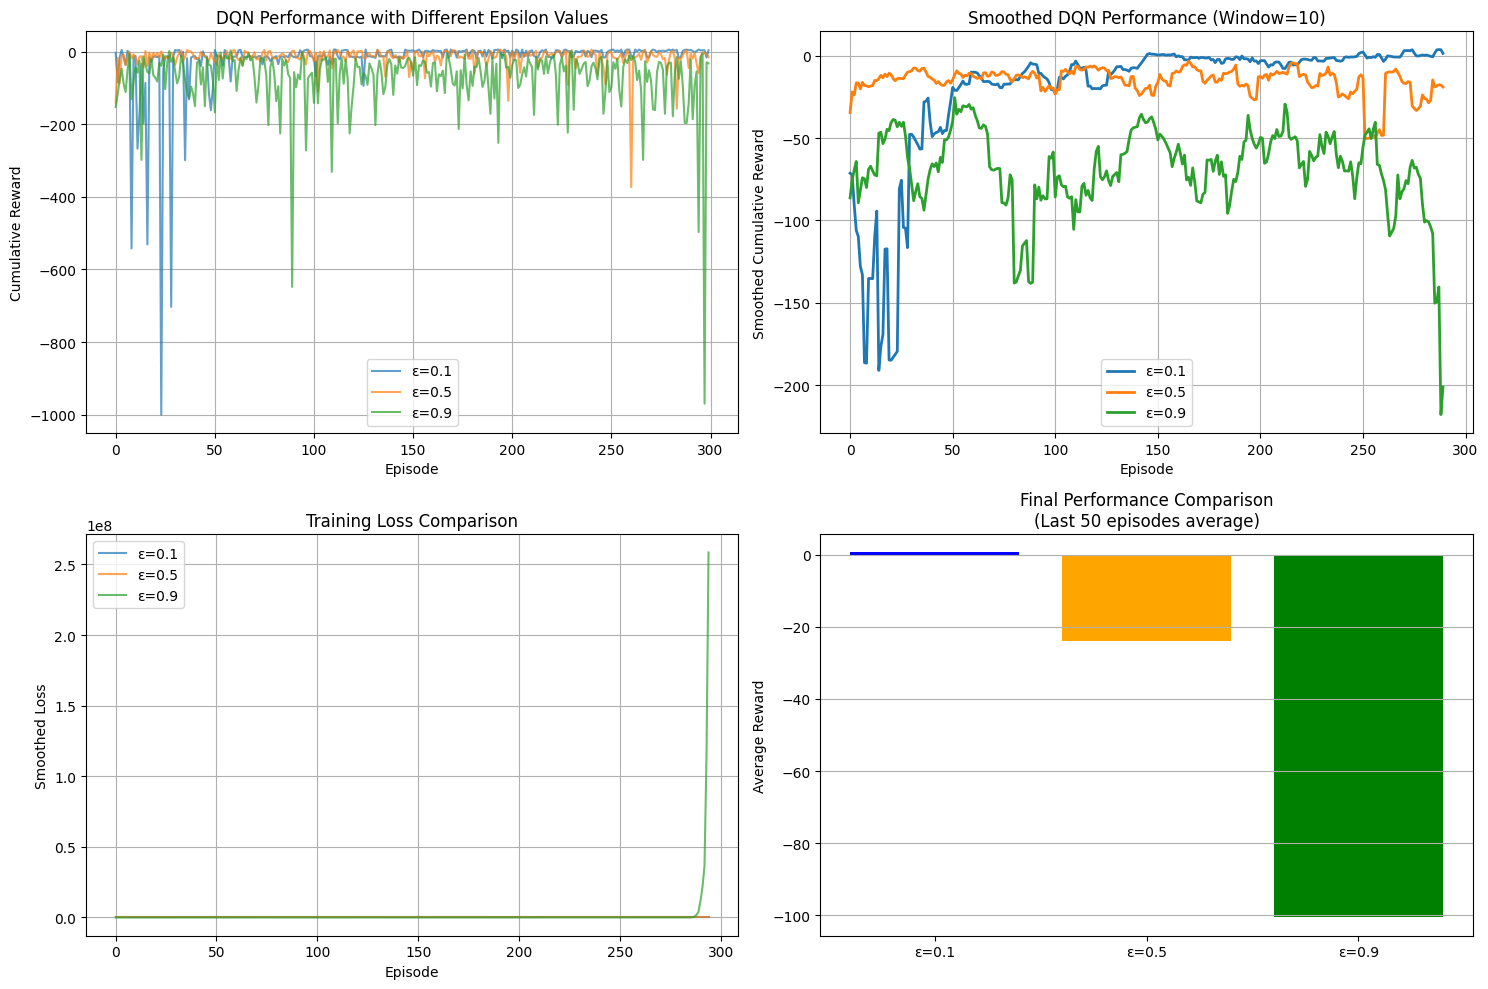

In [12]:
print("=== Testing DQN with Different Epsilon Values ===")
epsilon_values = [0.1, 0.5, 0.9]
results = {}

for epsilon in epsilon_values:
    print(f"Training with epsilon = {epsilon}")
    env = GridWorld()
    dqn_agent = DQNAgent(env, epsilon=epsilon)
    rewards, losses = play_dqn(env, dqn_agent, trials=300, learn=True)
    results[epsilon] = (rewards, losses)

# =============================================================================
# PLOTTING RESULTS - EXTENDS previous plotting
# =============================================================================
plt.figure(figsize=(15, 10))

# Plot 1: Raw performance
plt.subplot(2, 2, 1)
for epsilon in epsilon_values:
    rewards, _ = results[epsilon]
    plt.plot(rewards, label=f'ε={epsilon}', alpha=0.7)
plt.title('DQN Performance with Different Epsilon Values')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)

# Plot 2: Smoothed performance
plt.subplot(2, 2, 2)
for epsilon in epsilon_values:
    rewards, _ = results[epsilon]
    # Smooth the curve for better visualization
    window = 10
    smoothed_rewards = [np.mean(rewards[i:i+window]) for i in range(len(rewards)-window)]
    plt.plot(smoothed_rewards, label=f'ε={epsilon}', linewidth=2)
plt.title('Smoothed DQN Performance (Window=10)')
plt.xlabel('Episode')
plt.ylabel('Smoothed Cumulative Reward')
plt.legend()
plt.grid(True)

# Plot 3: Loss comparison
plt.subplot(2, 2, 3)
for epsilon in epsilon_values:
    _, losses = results[epsilon]
    smoothed_losses = [np.mean(losses[i:i+5]) for i in range(len(losses)-5)]
    plt.plot(smoothed_losses, label=f'ε={epsilon}', alpha=0.7)
plt.title('Training Loss Comparison')
plt.xlabel('Episode')
plt.ylabel('Smoothed Loss')
plt.legend()
plt.grid(True)

# Plot 4: Final performance comparison
plt.subplot(2, 2, 4)
final_rewards = [np.mean(results[eps][0][-50:]) for eps in epsilon_values]
plt.bar([f'ε={eps}' for eps in epsilon_values], final_rewards, color=['blue', 'orange', 'green'])
plt.title('Final Performance Comparison\n(Last 50 episodes average)')
plt.ylabel('Average Reward')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()


In [13]:
print("\n" + "="*60)
print("OBSERVATION DISCUSSION")
print("="*60)

print("\n1. ε=0.1 (Low Exploration):")
print("   - Learns quickly due to high exploitation")
print("   - May converge to suboptimal policy if exploration is insufficient")
print("   - Lower variance in rewards once converged")

print("\n2. ε=0.5 (Balanced):")
print("   - Good balance between exploration and exploitation")
print("   - More robust to local optima")
print("   - Moderate learning speed with good final performance")

print("\n3. ε=0.9 (High Exploration):")
print("   - Explores extensively, learns environment well")
print("   - Slower convergence due to frequent random actions")
print("   - Higher variance in learning curve")

print("\nKey Insights:")
print("- Lower epsilon (0.1) converges faster but might miss better policies")
print("- Higher epsilon (0.9) explores more but learns slower")
print("- Balanced epsilon (0.5) often provides best trade-off")
print("- DQN successfully replaces Q-table with neural network approximation")


OBSERVATION DISCUSSION

1. ε=0.1 (Low Exploration):
   - Learns quickly due to high exploitation
   - May converge to suboptimal policy if exploration is insufficient
   - Lower variance in rewards once converged

2. ε=0.5 (Balanced):
   - Good balance between exploration and exploitation
   - More robust to local optima
   - Moderate learning speed with good final performance

3. ε=0.9 (High Exploration):
   - Explores extensively, learns environment well
   - Slower convergence due to frequent random actions
   - Higher variance in learning curve

Key Insights:
- Lower epsilon (0.1) converges faster but might miss better policies
- Higher epsilon (0.9) explores more but learns slower
- Balanced epsilon (0.5) often provides best trade-off
- DQN successfully replaces Q-table with neural network approximation
